# Free energy surface

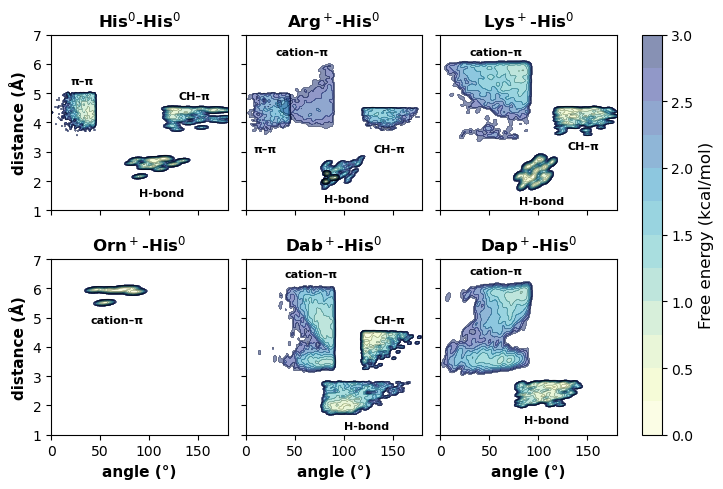

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import matplotlib.colors as mcolors

# --------------------
# constants
T   = 300.0                 # Kelvin
kB  = 0.008314462618        # kJ/mol/K
eps = 1e-12                 # avoid log(0)

# --------------------
# peptide systems: ( (file, label, (x,y)), ...,"title")
systems = [
    (
        ("1_MHH/pi_select.dat", "π–π", (20, 5.3)),
        ("1_MHH/cb_select.dat", "CH–π", (130, 4.8)),
        ("1_MHH/hb_select.dat", "H-bond", (90, 1.5)),
        "His$^0$-His$^0$"
    ),
    (
        ("2_MRH/cat_select.dat", "cation–π", (30, 6.3)),
        ("2_MRH/pi_select.dat", "π–π", (8, 3.0)),
        ("2_MRH/hd1_select.dat", "CH–π", (130, 3.0)),
        ("2_MRH/hh12_select.dat", "H-bond", None),  
        ("2_MRH/hh21_select.dat", "H-bond", (80, 1.3)),
        "Arg$^+$-His$^0$"
    ),
    (
        ("3_MKH/cat_select.dat", "cation–π", (30, 6.3)),
        ("3_MKH/he1_select.dat", "CH–π", (130, 3.1)),
        ("3_MKH/hz2_select.dat", "H-bond", (80, 1.2)),
        "Lys$^+$-His$^0$"  
    ),
    (
       ("4_MOH/cat_select.dat", "cation–π", (40, 4.8)),
        "Orn$^+$-His$^0$"
    ),
    (
        ("5_MbH/cat_select.dat", "cation–π", (40, 6.4)),
        ("5_MbH/hg2_select.dat", "CH–π", (130, 4.8)),
        ("5_MbH/hd3_select.dat", "H-bond", (100, 1.2)),
        "Dab$^+$-His$^0$"
    ),
    (
        ("6_MpH/cat_select.dat", "cation–π", (30, 6.5)),
        ("6_MpH/hg1_select.dat", "H-bond", (85, 1.4)),
        "Dap$^+$-His$^0$"
    )
]

# --------------------
# grid (shared for all)
x_grid = np.linspace(0, 180, 300)   # angle (deg)
y_grid = np.linspace(1, 7, 300)     # distance (Å)
X, Y   = np.meshgrid(x_grid, y_grid)
positions = np.vstack([X.ravel(), Y.ravel()])

# --------------------
# figure setup
fig, axes = plt.subplots(2, 3, figsize=(7.5, 5), sharex=True, sharey=True)
cmap = plt.get_cmap("YlGnBu")
levels = np.linspace(0, 3, 13)   
norm = mcolors.Normalize(vmin=0, vmax=3)

for ax, sys in zip(axes.flat, systems):
    *interactions, title = sys  # unpack interactions + title

    F_list = []

    for entry in interactions:
        # unpack (file, label, coords) safely
        if len(entry) == 3:
            dat_file, label, coords = entry
        else:
            dat_file, label = entry
            coords = None

        data = np.loadtxt(dat_file, comments=('#','@'))
        if data.ndim == 1:
            dist  = np.array([data[1]])
            angle = np.array([data[2]])
        else:
            dist  = data[:,1]
            angle = data[:,2]

        values = np.vstack([angle, dist])
        kde    = gaussian_kde(values)
        kde.set_bandwidth(bw_method=kde.factor * 0.4)

        P = kde(positions).reshape(X.shape) + eps
        F = -kB * T * np.log(P)
        F_kcal = F * 0.239005736
        F_list.append((F_kcal, label, coords))

    # normalize within peptide
    local_min = min(F.min() for F,_,_ in F_list)
    F_list = [(F - local_min, label, coords) for F,label,coords in F_list]

    # overlay interactions
    for F, label, coords in F_list:
        cf = ax.contourf(X, Y, F, levels=levels, cmap=cmap, norm=norm, alpha=0.5)
        ax.contour(X, Y, F, levels=levels, colors="k", linewidths=0.3, alpha=0.5)

        if coords is not None:
            lx, ly = coords
            ax.text(lx, ly, label, fontsize=8, weight="bold", color="black")

    ax.set_title(title, fontsize=12, weight="bold")

# shared labels
for ax in axes[1, :]:
    ax.set_xlabel("angle (°)", fontsize=11, weight="bold")
for ax in axes[:, 0]:
    ax.set_ylabel("distance (Å)", fontsize=11, weight="bold")

# shared colorbar
fig.tight_layout(rect=[0, 0, 0.92, 1])  
cbar = fig.colorbar(cf, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label("Free energy (kcal/mol)", fontsize=12)
plt.savefig("MXH_fes.jpg", dpi=300)
plt.show()